In [24]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import cv2
import shutil
from shutil import copyfile
from os import path

In [25]:
predict_dir = '/data1/icmr/shreyasi/brain_tumor_object_detection/predict/080124AIIMSD00001'
label_dir = '/data1/icmr/shreyasi/brain_tumor_object_detection/yolov5/runs/detect/exp/labels'
image_dir = '/data1/icmr/shreyasi/brain_tumor_object_detection/yolov5/runs/detect/exp'

In [26]:
# Make a dir to export jpgs to
if not os.path.exists(f'{predict_dir}'):
    os.mkdir(f'{predict_dir}')

In [27]:
# Copy YOLO
if not os.path.exists('/data1/icmr/shreyasi/brain_tumor_object_detection/yolov5'):
    shutil.copytree('/data1/icmr/shreyasi/brain_tumor_object_detection/yolov5-official-v31-dataset/yolov5', '/data1/icmr/shreyasi/brain_tumor_object_detection/yolov5')

In [28]:
# This function gives a basic plane from the ImageOrientationPatient tag. It doesn't account for obliqueness. But we don't need to care about it.
# Will return 'unknown' if the image isn't exactly orthogonal.
def get_image_plane(loc):
    row_x = round(loc[0])
    row_y = round(loc[1])
    row_z = round(loc[2])
    col_x = round(loc[3])
    col_y = round(loc[4])
    col_z = round(loc[5])
    if (row_x, row_y, col_x, col_y) == (1,0,0,0):
        return "coronal"
    if (row_x, row_y, col_x, col_y) == (0,1,0,0):
        return "sagittal"
    if (row_x, row_y, col_x, col_y) == (1,0,0,1):
        return "axial"
    return "Unknown"

In [29]:
# Call yolo detect.py on an image
def detect(plane):
    !python /data1/icmr/shreyasi/brain_tumor_object_detection/yolov5/detect.py --source {predict_dir} --weights /data1/icmr/shreyasi/brain_tumor_object_detection/output/{plane}_t1wce_2_class.pt --img 512 --exist-ok --save-txt 

In [30]:
# Delete all images and labels
def cleanup():
    if os.path.exists(label_dir):
        filelist = [ f for f in os.listdir(label_dir) if f.endswith(".txt") ]
        for f in filelist:
            os.remove(os.path.join(label_dir, f))

        filelist = [ f for f in os.listdir(image_dir) if f.endswith(".jpg") ]
        for f in filelist:
            os.remove(os.path.join(image_dir, f))
            
    filelist = [ f for f in os.listdir(predict_dir) if f.endswith(".jpg") ]
    for f in filelist:
        os.remove(os.path.join(predict_dir, f)) 

In [31]:
def detect_tumor(study, image_number):

    # Make sure there aren't files hanging around from the last run
    cleanup()

    # Load an image
    image = pydicom.dcmread(f'/data1/icmr/shreyasi/brain_tumor_object_detection/RSNA_MICCAI_Brain_Tumor_Radiogenomic_Classification/train/{study}/T1wCE/Image-{image_number}.dcm')
    pixels = image.pixel_array

    # Crunch pixels down to 8 bit
    pixels = pixels - np.min(pixels)
    pixels = pixels / np.max(pixels)
    pixels = (pixels * 255).astype(np.uint8)

    # Get the plane
    plane = get_image_plane(image.ImageOrientationPatient)
    print("Plane:", plane)

    # Expor the image as a JPG
    filename = f'{predict_dir}/{study}_t1wce_{image_number}.jpeg'
    cv2.imwrite(filename, pixels)
    
    # Run YOLO detect on the exported image
    detect(plane)
    
    # Get the YOLO image and label/BB coords .. if they exist
    image_name = f'{image_dir}/{study}_t1wce_{image_number}.jpeg'
    if os.path.isfile(image_name):
        img = cv2.imread(image_name)

        label_name = f'{label_dir}/{study}_t1wce_{image_number}.txt'
        if os.path.isfile(label_name):
            label_file = open(label_name, "r")
            label_text = label_file.read()

            fig, axes = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False, figsize=(10, 10))
            ax = axes.ravel()
            ax[0].set_title('Original')
            ax[0].imshow(pixels, cmap='gray')
            ax[1].set_title('OD Detect')
            ax[1].imshow(img, cmap='gray')

            plt.tight_layout()
            plt.show()

            print("Label/BB coords:", label_text)
        else:
            plt.figure(figsize= (6,6))
            plt.title('No Tumor Detected')
            plt.imshow(pixels, cmap='gray');

Plane: axial
detect: weights=['/data1/icmr/shreyasi/brain_tumor_object_detection/output/axial_t1wce_2_class.pt'], source=/data1/icmr/shreyasi/brain_tumor_object_detection/predict/080124AIIMSD00001, data=brain_tumor_object_detection/yolov5/data/coco128.yaml, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=brain_tumor_object_detection/yolov5/runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.8.19 torch-2.3.0 CUDA:0 (NVIDIA A40, 45403MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/3076 /data1/icmr/shreyasi/brain_tumor_object_detection/predict/080124AIIMSD00001/00414_t1wce_98.jpeg: 512x384 (no detections), 49.3ms
imag

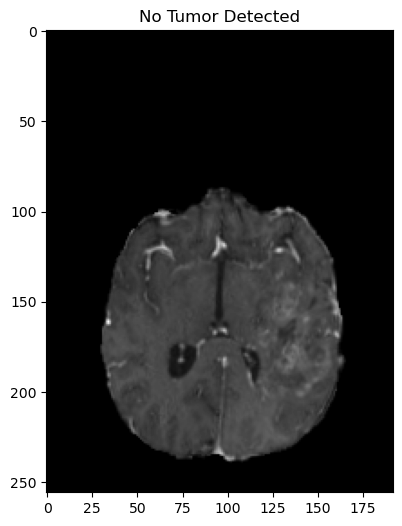

In [32]:
# Specify a study,series and image number and call the main function
study = '00414'
image_number = '98'

detect_tumor(study, image_number)